Вариант 1

Задание 1.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Результаты рассчета retention rate по дням могут помочь разработчикам игры выявить проблемы в игровом процессе или интерфейсе, которые могут отталкивать пользователей и приводить к низкому retention rate. Они также могут использоваться для сравнения эффективности различных стратегий удержания пользователей и определения наиболее успешных методов.

Решение:

В этом коде мы сначала загружаем данные из таблиц и соединяем их по идентификатору пользователя. В результате получается набор данных с полной информацией для интересующего нас анализа. Данную метрику имеет смысл анализировать за промежуток времени - неделя, месяц или год, а не за все 12 лет. Берём для анализа сэмпл данных  за последний месяц работы игры.

Далее преобразуем столбцы с датами в формат datetime. Затем определяем промежуток времени прошедший с момента регистрации каждого из игроков в нашем наборе данных. Группируем данные по дате регистрации и времени прошедшему с момнета регистрации агрегируя по уникальным user id, разделяя т.о. на группы. Создаём сводную таблицу с результатми, рассчитывая retention rate как отношение количества дней после регистрации пользователя, в которые он был активен (заходил в игру) к количетсву дней, которые прошли с даты регистрации.

В заключении строим график для наглядности. 

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import datetime
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
reg_data = pd.read_csv(reg_data_path, sep=';')
auth_data = pd.read_csv(auth_data_path, sep=';')

In [17]:
reg_data ['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit ='s').dt.date
reg_data

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,2000-01-13,3,2000-01-13
3,2000-05-28,4,2000-05-28
4,2000-09-16,5,2000-09-16
...,...,...,...
999995,2020-09-23,1110618,2020-09-23
999996,2020-09-23,1110619,2020-09-23
999997,2020-09-23,1110620,2020-09-23
999998,2020-09-23,1110621,2020-09-23


In [14]:
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [15]:
auth_data ['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit ='s').dt.date
auth_data

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [6]:
def calculate_retention(reg_data_path, auth_data_path, start_date, end_date):

    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

#Чтение CSV-файлов
    reg_data = pd.read_csv(reg_data_path, sep=';')
    auth_data = pd.read_csv(auth_data_path, sep=';')
    
#Объединение данных по полям 'uid' и 'reg_ts'
    data = pd.merge(auth_data, reg_data, on=['uid'])
    
#Преобразуем столбцы с датами в формат datetime
    data['reg_ts'] = pd.to_datetime(data['reg_ts'], unit ='s').dt.date
    data['auth_ts'] = pd.to_datetime(data['auth_ts'], unit ='s').dt.date

    data= data.query('reg_ts >= @start_date and reg_ts<=@end_date')
    data= data.query('auth_ts >= @start_date and auth_ts <= @end_date')    

#Добавляем столбец с разницей дат в днях, чтобы понять, сколько времени прошло с регистрации
    data['days_reg'] = (data['auth_ts'] - data['reg_ts']).dt.days 
    
#Группируем по дате регистрации и дням   
    data = data.groupby(['reg_ts', 'days_reg']).agg({'uid': 'nunique'}) 
    
#Создаём сводую таблицу с результатми рассчёта   
    data = data.reset_index().pivot(index='reg_ts', columns='days_reg', values='uid')
    data = data.div(data[0], axis=0).mul(100).round(2)
    
#В первый день периода рассчёта метрики её значение всегда будет 100%, по этому первую строку
#удаляем для более корректного вывода 
    data = data.drop(labels = [0],axis = 1)
    
#Визуализация    
    sns.set(style='ticks', rc={"figure.figsize": (20, 10)}) 
    plt.title('Retention rate')
    sns.heatmap(data=data.div(100, axis=0), annot=True,  fmt='.0%', vmin=0.0, vmax=0.15, cmap='Blues')
        
    return data

In [7]:
#присвоение переменным путей к файлам данных для передачи их в функцию
#reg_data_path = 'problem1-reg_data.csv'
#auth_data_path = 'problem1-auth_data.csv'
start_date = '2020-08-23'
end_date = '2020-09-23'
auth_data_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-poljanskij-38/shared/problem1-auth_data.csv'
reg_data_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-poljanskij-38/shared/problem1-reg_data.csv'

days_reg,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-23,2.50,3.84,4.87,4.93,6.98,8.19,5.70,5.12,4.55,6.72,...,4.42,3.39,3.91,3.14,3.65,4.16,2.88,3.07,3.39,1.79
2020-08-24,1.79,4.15,4.28,5.11,5.75,7.60,6.01,4.92,5.18,5.18,...,3.64,3.45,4.47,3.13,3.26,3.13,3.13,2.81,1.28,NaN
2020-08-25,1.98,4.40,4.79,5.68,5.30,5.30,6.25,3.70,5.74,4.72,...,3.57,3.25,3.25,4.40,2.81,3.13,3.19,2.30,NaN,NaN
2020-08-26,1.46,3.44,4.20,4.52,6.43,6.56,5.99,4.59,4.33,4.08,...,4.27,3.25,2.74,2.93,2.80,2.74,1.66,NaN,NaN,NaN
2020-08-27,1.65,3.37,4.77,5.21,5.53,6.17,5.72,4.32,5.40,5.40,...,2.99,2.99,3.88,3.37,2.73,1.46,NaN,NaN,NaN,NaN
2020-08-28,2.03,4.57,5.27,4.76,6.29,6.22,5.46,5.59,5.27,4.83,...,4.70,4.06,2.86,3.68,2.54,NaN,NaN,NaN,NaN,NaN
2020-08-29,2.53,3.74,4.63,5.70,5.51,6.97,5.70,4.56,6.02,4.31,...,4.25,3.49,3.55,1.71,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-30,1.84,3.48,3.92,5.38,5.95,6.58,5.57,4.30,4.30,5.19,...,4.05,3.73,1.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,1.83,3.66,4.23,5.12,6.89,6.51,6.70,4.80,5.37,5.05,...,2.78,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


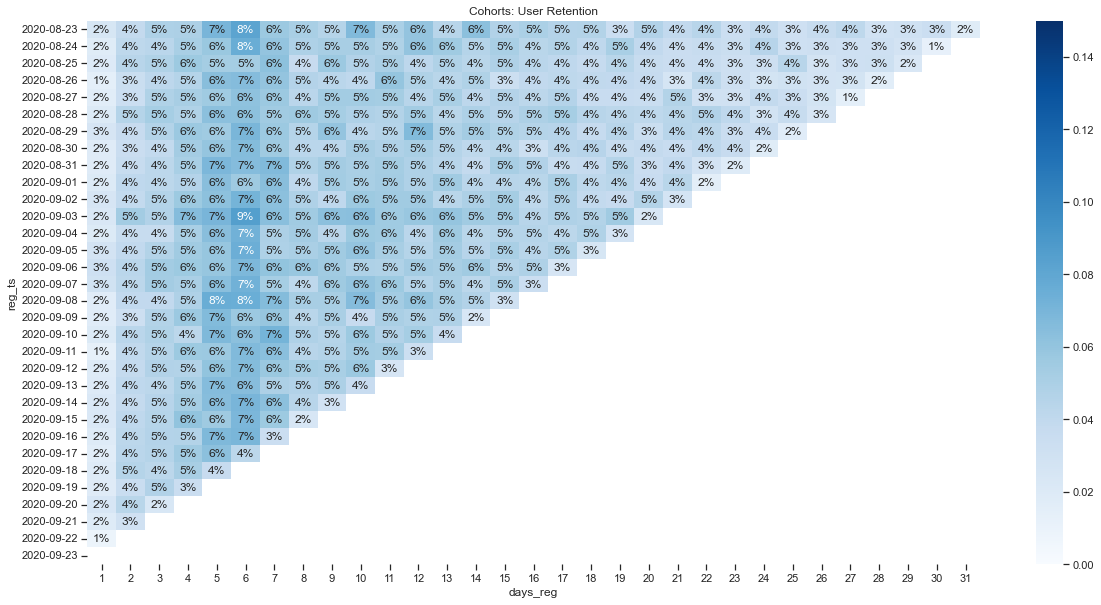

In [8]:
# использование функции на сэмпле данных
calculate_retention(reg_data_path, auth_data_path,start_date,end_date)

Результаты анализа и выводы:

Как видно на графике, показатель retention rate по дням больше в период с 5-7 день после регистрации. Это говорит нам о том, что в конце первой недели, для пользователей, скорее всего, предусмотрены какие-либо "плюшки" в виде подарков, скидок или спец предложений. Начиная со второй неделеи после регистрации идёт стабильное понижение метрики. 
Нам не известно точно, какие акции проводятся 5-7 день после регистрации, но, для повышения возвращаемости игроков, стоит рассмотреть вариант о проведении таких акций регулярно - несколько раз в месяц.

Задание 2.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Решение:

Для принятия правильного решения о том, какой набор предложений лучше, необходимо проанализировать несколько метрик:

1. ARPU (Average Revenue Per User) - средний доход на одного пользователя. В данном случае ARPU в тестовой группе выше на 5%, что говорит о том, что набор предложений в тестовой группе более эффективен. Однако, в данных присутствуют не платящие пользователи, по этому имеет смысл проанализировать метрику ARPPU.

2. ARPPU - показывает, сколько в среднем денег тратит один платящий пользователь. Для расчета ARPPU нужно разделить выручку на количество платящих пользователей. Получилось, что данная метрика в контрольной (выручка = 5136189) группе 2663.99 меньше чем в тестовой выручка = 5421603) 3003.65.

3. Conversion rate - коэффициент конверсии, то есть отношение числа платящих пользователей к общему числу пользователей. В контрольной группе конверсия составила 1928 / 202103 = 0,0095 (0,95%), а в тестовой группе - 1805 / 202667 = 0,0089 (0,89%). Таким образом, конверсия в контрольной группе выше на 0,06 процентных пункта.

5. Для принятия правильного решения нужно также провести статистический анализ результатов A/B теста. Также стоит учитывать бюджет и затраты на проведение теста и реализацию нового набора предложений. (данной информации у нас нет).

In [1]:
#импортируем нужные библиотеки и читаем данные из CSV файла
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
import scipy.stats as stats

from tqdm.auto import tqdm
from scipy.stats import norm

#загрузка данных
data = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

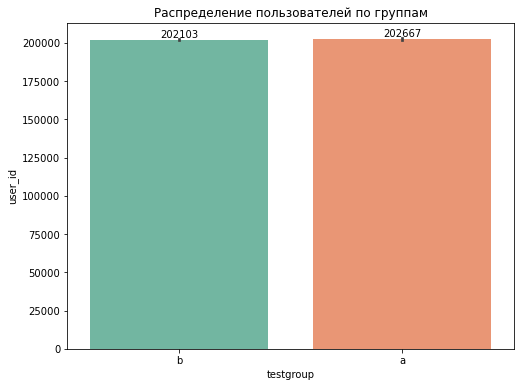

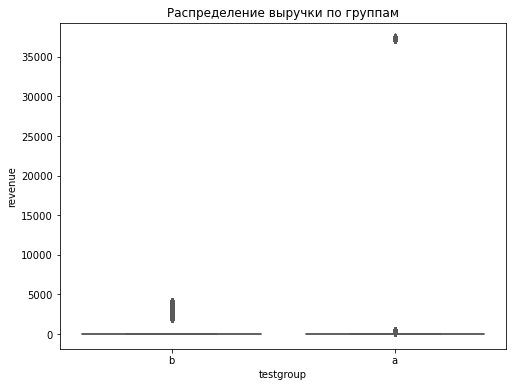

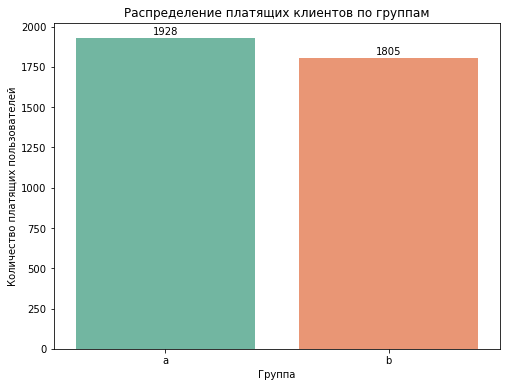

In [8]:
#Исследуем данные и визуализируем распределение данных по тестовой и контрольной группе.

#Посмотрим, как распределены пользователи в тестовой и контрольной группе

users_grouped = data.groupby('testgroup').agg({'user_id': 'count', 'revenue': 'sum'}).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='testgroup', y='user_id', data=data, palette='Set2')

# Добавляем значения над каждым баром
for i, value in enumerate(users_grouped['user_id']):
    ax.text(i, value + 50, str(value), ha='center', va='bottom')

plt.title('Распределение пользователей по группам')
plt.show()

# Посмотрим, как распределена выручка в тестовой и контрольной группе с помощью боксплота

plt.figure(figsize=(8, 6))
sns.boxplot(x='testgroup', y='revenue', data=data, palette='Set2')
plt.title('Распределение выручки по группам')
plt.show()


#В графике распределения выручки мы видим большой выброс в контрольной группе. При проведении дальнейших 
#тестов для этих групп стоит это учитывать.


# Визуализируем, как распределены платящие клиенты по разным группам
users_pay = data.query('revenue > 0')\
                       .groupby('testgroup', as_index=False)\
                       .agg({'user_id': 'count'})

plt.figure(figsize=(8, 6))
sns.barplot(x='testgroup', y='user_id', data=users_pay, palette='Set2')
plt.title('Распределение платящих клиентов по группам')
plt.xlabel('Группа')
plt.ylabel('Количество платящих пользователей')

for index, value in enumerate(users_pay['user_id']):
    plt.text(index, value + 10, str(value), ha='center', va='bottom')

plt.show()

In [9]:
#разбиваем данные теста на группы и выделяем группы платящих пользователей

control_a = data[data['testgroup'] == 'a']
test_b = data[data['testgroup'] == 'b']

control_a_payed = control_a.query('revenue>0') #платящие пользователи из контрольной группы
test_b_payed = test_b.query('revenue>0') #платящие пользователи из тестовой группы

In [10]:
#считаем количество чеков по суммам чеков и строим гистограммы для понимания распределения сумм покупок
#в группах платящих пользователей из контрольной  и тестовой групп

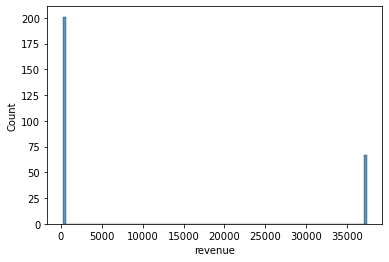

In [11]:
#контрольная группа А
bill_a=control_a_payed.groupby('revenue').agg({'user_id':'count'}) \
                      .reset_index().rename(columns={'user_id':'revenue_count'})

snsplot = sns.histplot(bill_a['revenue'],bins=100)
fig = snsplot.get_figure()

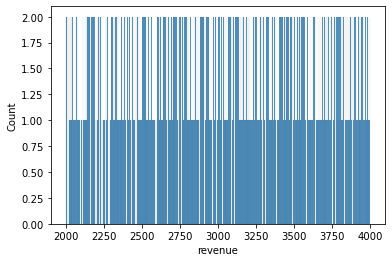

In [12]:
#тестовая группа В
bill_b=test_b_payed.groupby('revenue').agg({'user_id':'count'}) \
                   .reset_index().rename(columns={'user_id':'revenue_count'})

snsplot = sns.histplot(bill_b['revenue'],bins=1000)
fig = snsplot.get_figure()

In [ ]:
#Так как обе выборки достаточно большие, то для оценки статистического анализа средних значений, таких 
#как ARPU и ARPPU, можно использовать обычный t-тест. Т-тест не требует нормальности распределения выборок, что,
#так же, позволяет нам его применить.

In [ ]:
#Анализ ARPU

In [13]:
arpu_df = data.groupby('testgroup').agg({'revenue':'sum','user_id':'count' }).reset_index()
arpu_df ['arpu'] = arpu_df['revenue']/arpu_df['user_id']
print('ARPU in group A = ', arpu_df['arpu'][0])
print('ARPU in group B = ', arpu_df['arpu'][1])
arpu_df

ARPU in group A =  25.413719736965806
ARPU in group B =  26.75128659327863


,testgroup,revenue,user_id,arpu
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


In [38]:
#T-test для ARPU, с учётом неоднородности дисперсий

arpu_c = data[data['testgroup'] == 'a']['revenue']
arpu_t = data[data['testgroup'] == 'b']['revenue']

ttest_arpu = ttest_ind(arpu_c, arpu_t, equal_var=False)
p = ttest_arpu.pvalue

print('T-test результаты для ARPU: p-value =', p)

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')


T-test результаты для ARPU: p-value = 0.5329647014130866
Не отклоняем H0


In [ ]:
#Анализ ARPPU

In [28]:
#рассчитываем и выводим данные о значениях метрики ARPPU, общей выручки и количества платящих пользователей 
#по группам
arppu_df = data.query('revenue>0').groupby('testgroup').agg({'revenue':'sum','user_id':'count' }).reset_index()
arppu_df ['arppu'] = arppu_df['revenue']/arppu_df['user_id']
print('ARPPU in group A = ', arppu_df['arppu'][0])
print('ARPPU in group B = ', arppu_df['arppu'][1])
arppu_df

ARPPU in group A =  2663.9984439834025
ARPPU in group B =  3003.6581717451522


,testgroup,revenue,user_id,arppu
0,a,5136189,1928,2663.998444
1,b,5421603,1805,3003.658172


In [42]:
#T-test для ARPPU, с учётом неоднородности дисперсий

arppu_c = control_a_payed['revenue']
arppu_t = test_b_payed['revenue']

ttest_arppu = ttest_ind(arppu_c, arppu_t, equal_var=False)
p = ttest_arpu.pvalue

print('T-test результаты для ARPPU: p-value =', p)

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')



T-test результаты для ARPPU: p-value = 0.5329647014130866
Не отклоняем H0


In [43]:
#создаём список пользователей создающих выброс и считаем долю выручки которую приносят пользователи из 
#выброса и все остальные платящие пользователи в контрольной группе А

uid_overload_list_a = control_a_payed.query('revenue>5000').user_id.tolist()

#выручка приносимая пользователями из выброса
revenue_overload_total_a = control_a_payed[control_a_payed['user_id'] \
                                           .isin(uid_overload_list_a)].agg({'revenue':'sum'})
#доля приносимая пользователями из выброса выручки от общей                                                         
x = revenue_overload_total_a/arppu_df['revenue'][0]

print ('Доля выручки, которую дают 123 платящих пользователя в контрольной группе А',x)
print ('Доля выручки, которую дают 1805 платящих пользователя в контрольной группе А',1-x)

Доля выручки, которую дают 123 платящих пользователя в контрольной группе А revenue    0.893708
dtype: float64
Доля выручки, которую дают 1805 платящих пользователя в контрольной группе А revenue    0.106292
dtype: float64


In [44]:
#Анализ конверсии

In [45]:
#Для оценки статистических различий конверсии в двух группах будем использовать критерий Хи-квадрат. 
#Данный критерий применяется когда нет необходимости знать величину того или иного параметра 
#(среднюю или относительную величину), а требуется оценить достоверность различий двух или более групп, 
#подтвердить, существенно ли влияние изучаемого фактора или оно случайно.
#Н0 - статистически значимых различий между результатами контрольной и тестовой группы нет
#Н1 - различия есть.

In [46]:
#считаем конверсию и создаём датафрэйм с необходимым для анализа набором данных по группам

cr_df = {'testgroup': ["a", "b"], 'payed': [len(control_a.query("revenue > 0")), 
                                           len(test_b.query("revenue > 0"))], 
         'not_payed': [len(control_a.query("revenue == 0")), 
                      len(test_b.query("revenue == 0"))]}
cr_df = pd.DataFrame(data=cr_df)
cr_df = cr_df.set_index('testgroup').reset_index()
cr_df['cr'] = cr_df['payed'] / cr_df['not_payed']

In [47]:
cr_df

,testgroup,payed,not_payed,cr
0,a,1928,200175,0.009632
1,b,1805,200862,0.008986


In [48]:
#проверяем критерием хи-вадрат

from scipy.stats import chi2_contingency
cr_chi2 = chi2_contingency(cr_df[['payed', 'not_payed']])

In [49]:
print('P value = ', cr_chi2[1])

P value =  0.03647561892312613


In [ ]:
#P-value=0.0365, что позволяет отклонить нулевую гипотезу

Анализ и выводы:
1. ARPU в тестовой группе выше на 5%. Статистически значимых различий нет.

2. ARPPU в контрольной (выручка = 5136189) группе 2663.99 меньше чем в тестовой выручка = 5421603) 3003.65. Статистически значимых различий нет.

3. Conversion rate в контрольной группе составила 0,0095 (0,95%), а в тестовой группе 0,0089 (0,89%). Таким образом, конверсия в контрольной группе выше на 0,06 процентных пункта. Статистически значимые различия есть.

4. Чтобы более точно интерпретировать выброс в распределении по суммам чеков в контрольной группе, необхоидмо знать дизайн АВ-теста. Судя по однородности сумм, в тестовой группе, проверялись новые предложения нацеленные именно на такой результат, в то время как, в контрольной группе остались предложения разных ценовых категорий, в том числе больших.

Принимая во внимание выводы проведённого анализа, тестовый набор предложений можно считать лучшим. Однако, по сути, целевой результат в группах - размер выручки, различается не сильно, в то время как, количество пользователей, создающих этот результат, различается на порядок. Можно порекомендовать провести АВ-тест более прицельно - оставив исходный набор предложений для группы пользователей, покупающих на большие суммы, для остальных же, выдавать новый набор предложений. Предположительно, это может увеличить суммарную выручку.

Задание 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Сценарий 1: Обычные тематические события**

Для оценки результатов последнего события, где игроки должны пройти ряд уровней за ограниченное время, можно использовать следующие метрики:

1. Conversion rate - показывает, сколько игроков, начавших участие в событии, добрались до последнего уровня и получили награду. Эта метрика позволяет оценить эффективность дизайна уровней и сложности заданий, а также понять, насколько привлекательны награды для игроков.

2. Retention rate - показывает, сколько игроков, начавших участие в событии, продолжили играть и завершили все уровни. Эта метрика позволяет оценить удержание игроков в игре и эффективность маркетинговых кампаний, направленных на привлечение новых пользователей.

3. Average session length - показывает, сколько времени игроки проводят в игре в рамках события. Эта метрика позволяет оценить интересность и привлекательность события для игроков, а также определить оптимальную продолжительность следующих тематических событий.

4. Revenue per user - показывает, сколько денег каждый игрок принес в игру в рамках события. Эта метрика позволяет оценить эффективность монетизации события и понять, насколько привлекательны награды для игроков.

5. Churn rate - показывает, сколько игроков покинули игру после окончания события. Эта метрика позволяет оценить эффективность удержания игроков и определить причины оттока пользователей.

**Сценарий 2: Сложные тематические события с откатом уровней**

В случае усложненной механики с откатом уровней при неудачной попытке:

1. Drop-off rate - показывает, на каком уровне игроки чаще всего отказываются от участия в событии и покидают игру. Эта метрика поможет определить, на каком уровне игры требуется улучшение, чтобы увеличить удержание игроков.

2. Retry rate - показывает, сколько раз игроки пытаются пройти уровень после неудачной попытки. Эта метрика поможет определить сложность уровней и понять, насколько она соответствует ожиданиям пользователей.

3. Time to complete - показывает, сколько времени требуется игрокам для прохождения каждого уровня с откатом назад. Эта метрика поможет определить, насколько эффективно была настроена сложность уровней и дизайн игрового процесса.

4. Average revenue per retry - показывает, сколько денег каждый игрок тратит на повторные попытки пройти уровень после неудачной попытки. Эта метрика поможет оценить эффективность монетизации события и понять, насколько привлекательны награды для игроков.

5. Completion rate - показывает, сколько игроков успешно завершили все уровни с откатом назад. Эта метрика позволяет оценить эффективность дизайна уровней и сложности заданий, а также понять, насколько привлекательны награды для игроков.

**Вывод:**

В каждом из сценариев важно анализировать различные аспекты влияния событий на поведение и монетизацию игроков. Сочетание количественных и качественных метрик поможет сделать более полное представление об успешности тематического события.